In [1]:
import radical.analytics as ra
import radical.pilot as rp
import radical.utils as ru
import radical.entk as re
import os
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import csv
import pandas as pd
import json
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True

blues = cm.get_cmap(plt.get_cmap('Blues'))
greens = cm.get_cmap(plt.get_cmap('Greens'))
reds = cm.get_cmap(plt.get_cmap('Reds'))
oranges = cm.get_cmap(plt.get_cmap('Oranges'))
purples = cm.get_cmap(plt.get_cmap('Purples'))
greys = cm.get_cmap(plt.get_cmap('Greys'))

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
!radical-stack


  python               : 2.7.15
  pythonpath           : 
  virtualenv           : python2

  radical.analytics    : 0.70.0
  radical.entk         : 0.70.0
  radical.pilot        : 0.70.0
  radical.saga         : 0.70.0
  radical.utils        : 0.70.0



## Design 1

In [2]:
!tar -xzvf ../Data/Design1/entk.session-design1-54875/entk.session-design1-54875.tar.gz -C ../Data/Design1/entk.session-design1-54875/
!tar -xzvf ../Data/Design1/entk.session-design1-54875/entk_workflow.tar.gz -C ../Data/Design1/entk.session-design1-54875/

x entk.session-design1-54875.json
x entk_workflow.json


In [3]:
des1DF = pd.DataFrame(columns=['TTX','AgentOverhead','ClientOverhead','EnTKOverhead'])
work_file = open('../Data/Design1/entk.session-design1-54875/entk_workflow.json')
work_json = json.load(work_file)
work_file.close()

workflow = work_json['workflows'][1]
unit_ids = list()
for pipe in workflow['pipes']:
    unit_path = pipe['stages'][1]['tasks'][0]['path']
    unit_id = unit_path.split('/')[-2]
    if unit_id != 'unit.000000':
        unit_ids.append(unit_id)

sids=['entk.session-design1-54875']
for sid in sids:
    re_session = ra.Session(stype='radical.entk',src='../Data/Design1',sid=sid)
    rp_session = ra.Session(stype='radical.pilot',src='../Data/Design1/'+sid)
    units = rp_session.filter(etype='unit', inplace=False, uid=unit_ids)
    pilot = rp_session.filter(etype='pilot', inplace=False)
    units_duration = units.duration(event=[{ru.EVENT: 'exec_start'},{ru.EVENT: 'exec_stop'}])
    units_agent = units.duration (event=[{ru.EVENT: 'state',ru.STATE: rp.AGENT_STAGING_INPUT},{ru.EVENT: 'staging_uprof_stop'}])
    all_units = rp_session.filter(etype='unit', inplace=False)
    disc_unit = rp_session.filter(etype='unit', inplace=False, uid='unit.000000')
    disc_time = disc_unit.duration([rp.NEW, rp.DONE])
    units_client = units.duration([rp.NEW, rp.DONE])
    appmanager = re_session.filter(etype='appmanager',inplace=False)
    t_p2 = pilot.duration(event=[{ru.EVENT: 'bootstrap_0_start'}, {ru.EVENT: 'cmd'}])
    resource_manager = re_session.filter(etype='resource_manager',inplace=False)
    app_duration = appmanager.duration(event=[{ru.EVENT:"amgr run started"},{ru.EVENT:"termination done"}])
    res_duration = resource_manager.duration(event=[{ru.EVENT:"rreq submitted"},{ru.EVENT:"resource active"}])
    ttx = units_duration
    agent_overhead = abs(units_agent - units_duration)
    client_overhead = units_client - units_agent
    entk_overhead =  app_duration - units_client - res_duration - all_units.duration(event=[{ru.EVENT: 'exec_start'},{ru.EVENT: 'exec_stop'}]) + ttx
    des1DF.loc[len(des1DF)] = [ttx, agent_overhead, client_overhead, entk_overhead]

In [4]:
print(des1DF)

            TTX  AgentOverhead  ClientOverhead  EnTKOverhead
0  11717.529445     978.254925    45306.359832  12857.508548


## Design 2

In [5]:
des2DF = pd.DataFrame(columns=['TTX','SetupOverhead','SetupOverhead2','AgentOverhead','ClientOverhead'])
sids = ['design2_11K_run5'] 
for sid in sids:
    Node1 = pd.DataFrame(columns=['Start','End','Type'])
    Node1Tilling = pd.read_csv('../Data/Design2/'+sid+'/pilot.0000/unit.000002/geolocate1.csv')
    for index,row in Node1Tilling.iterrows():
        Node1.loc[len(Node1)] = [row['Start'],row['End'],'Geo1']
    Node1Tilling = pd.read_csv('../Data/Design2/'+sid+'/pilot.0000/unit.000002/geolocate2.csv')
    for index,row in Node1Tilling.iterrows():
        Node1.loc[len(Node1)] = [row['Start'],row['End'],'Geo2']
    Node1Tilling = pd.read_csv('../Data/Design2/'+sid+'/pilot.0000/unit.000002/ransac1.csv')
    for index,row in Node1Tilling.iterrows():
        Node1.loc[len(Node1)] = [row['Start'],row['End'],'Ransac1']
    Node2 = pd.DataFrame(columns=['Start','End','Type'])
    Node2Tilling = pd.read_csv('../Data/Design2/'+sid+'/pilot.0000/unit.000003/geolocate3.csv')
    for index,row in Node2Tilling.iterrows():
        Node2.loc[len(Node2)] = [row['Start'],row['End'],'Geo3']
    Node2Tilling = pd.read_csv('../Data/Design2/'+sid+'/pilot.0000/unit.000003/geolocate4.csv')
    for index,row in Node2Tilling.iterrows():
        Node2.loc[len(Node2)] = [row['Start'],row['End'],'Geo4']
    Node2Tilling = pd.read_csv('../Data/Design2/'+sid+'/pilot.0000/unit.000003/ransac2.csv')
    for index,row in Node2Tilling.iterrows():
        Node2.loc[len(Node2)] = [row['Start'],row['End'],'Ransac2']
    Node3 = pd.DataFrame(columns=['Start','End','Type'])
    Node3Tilling = pd.read_csv('../Data/Design2/'+sid+'/pilot.0000/unit.000004/geolocate5.csv')
    for index,row in Node3Tilling.iterrows():
        Node3.loc[len(Node3)] = [row['Start'],row['End'],'Geo5']
    Node3Tilling = pd.read_csv('../Data/Design2/'+sid+'/pilot.0000/unit.000004/geolocate6.csv')
    for index,row in Node3Tilling.iterrows():
        Node3.loc[len(Node3)] = [row['Start'],row['End'],'Geo6']
    Node3Tilling = pd.read_csv('../Data/Design2/'+sid+'/pilot.0000/unit.000004/ransac3.csv')
    for index,row in Node3Tilling.iterrows():
        Node3.loc[len(Node3)] = [row['Start'],row['End'],'Ransac3']
    Node4 = pd.DataFrame(columns=['Start','End','Type'])
    Node4Tilling = pd.read_csv('../Data/Design2/'+sid+'/pilot.0000/unit.000005/geolocate7.csv')
    for index,row in Node4Tilling.iterrows():
        Node4.loc[len(Node4)] = [row['Start'],row['End'],'Geo7']
    Node4Tilling = pd.read_csv('../Data/Design2/'+sid+'/pilot.0000/unit.000005/geolocate8.csv')
    for index,row in Node4Tilling.iterrows():
        Node4.loc[len(Node4)] = [row['Start'],row['End'],'Geo8']
    Node4Tilling = pd.read_csv('../Data/Design2/'+sid+'/pilot.0000/unit.000005/ransac4.csv')
    for index,row in Node4Tilling.iterrows():
        Node4.loc[len(Node4)] = [row['Start'],row['End'],'Ransac4']
    AllNodes = pd.DataFrame(columns=['Start','End','Type'])
    AllNodes = AllNodes.append(Node1)
    AllNodes = AllNodes.append(Node2)
    AllNodes = AllNodes.append(Node3)
    AllNodes = AllNodes.append(Node4)
    AllNodes.reset_index(inplace=True,drop='index')
    rp_sessionDes2 = ra.Session(stype='radical.pilot',src='../Data/Design2/'+sid)
    unitsDes2 = rp_sessionDes2.filter(etype='unit', inplace=False)
    execUnits = unitsDes2.filter(uid=['unit.000002','unit.000003','unit.000004','unit.000005'],inplace=False)
    exec_units_setup_des2 = execUnits.duration(event=[{ru.EVENT: 'exec_start'},{ru.EVENT: 'exec_stop'}])
    exec_units_agent_des2 = execUnits.duration([rp.AGENT_STAGING_INPUT, rp.UMGR_STAGING_OUTPUT_PENDING])
    exec_units_clientDes2 = execUnits.duration([rp.NEW, rp.DONE])
    SetupUnit = unitsDes2.filter(uid=['unit.000000'],inplace=False)
    setup_units_clientDes2 = SetupUnit.duration(event=[{ru.STATE: rp.NEW},{ru.EVENT: 'exec_start'}])
    pilotDes2 = rp_sessionDes2.filter(etype='pilot', inplace=False)
    pilot_duration = pilotDes2.duration([rp.PMGR_ACTIVE,rp.FINAL])
    des2_duration = AllNodes['End'].max() - AllNodes['Start'].min()
    setupDes2_overhead = exec_units_setup_des2 - des2_duration
    agentDes2_overhead = exec_units_agent_des2 - exec_units_setup_des2
    clientDes2_overhead = exec_units_clientDes2 - exec_units_agent_des2
    des2DF.loc[len(des2DF)] = [des2_duration, setup_units_clientDes2, setupDes2_overhead, agentDes2_overhead, clientDes2_overhead]

In [6]:
print(des2DF)

           TTX  SetupOverhead  SetupOverhead2  AgentOverhead  ClientOverhead
0  6703.852195      81.679263        7.051244        0.18611       22.274512


## Design 2A

In [7]:
sid='../Data/Design2a/design2a_11k_test5/'
rp_sessionDes2 = ra.Session(stype='radical.pilot',src=sid)
unitsDes2 = rp_sessionDes2.filter(etype='unit', inplace=False)
execUnits = unitsDes2.filter(uid=['unit.000002','unit.000003','unit.000004','unit.000001'],inplace=False)
exec_units_setup_des2 = execUnits.duration(event=[{ru.EVENT: 'exec_start'},{ru.EVENT: 'exec_stop'}])
exec_units_agent_des2 = execUnits.duration([rp.AGENT_STAGING_INPUT, rp.UMGR_STAGING_OUTPUT_PENDING])
exec_units_clientDes2 = execUnits.duration([rp.NEW, rp.DONE])
SetupUnit = unitsDes2.filter(uid=['unit.000000'],inplace=False)
setup_units_clientDes2 = SetupUnit.duration(event=[{ru.STATE: rp.NEW},{ru.EVENT: 'exec_start'}])
pilotDes2 = rp_sessionDes2.filter(etype='pilot', inplace=False)

In [8]:
Node1 = pd.DataFrame(columns=['Start','End','Type'])
Node1Tilling = pd.read_csv('../Data/Design2a/design2a_11k_test5/pilot.0000/unit.000000/geolocate1.csv')
for index,row in Node1Tilling.iterrows():
    Node1.loc[len(Node1)] = [row['Start'],row['End'],'Geo1']
Node1Tilling = pd.read_csv('../Data/Design2a/design2a_11k_test5/pilot.0000/unit.000000/geolocate2.csv')
for index,row in Node1Tilling.iterrows():
    Node1.loc[len(Node1)] = [row['Start'],row['End'],'Geo2']

Node1Tilling = pd.read_csv('../Data/Design2a/design2a_11k_test5/pilot.0000/unit.000000/ransac1.csv')
for index,row in Node1Tilling.iterrows():
    Node1.loc[len(Node1)] = [row['Start'],row['End'],'Ransac1']


In [9]:
Node2 = pd.DataFrame(columns=['Start','End','Type'])
Node2Tilling = pd.read_csv('../Data/Design2a/design2a_11k_test5/pilot.0000/unit.000001/geolocate3.csv')
for index,row in Node2Tilling.iterrows():
    Node2.loc[len(Node2)] = [row['Start'],row['End'],'Geo3']
Node2Tilling = pd.read_csv('../Data/Design2a/design2a_11k_test5/pilot.0000/unit.000001/geolocate4.csv')
for index,row in Node2Tilling.iterrows():
    Node2.loc[len(Node2)] = [row['Start'],row['End'],'Geo4']

Node2Tilling = pd.read_csv('../Data/Design2a/design2a_11k_test5/pilot.0000/unit.000001/ransac2.csv')
for index,row in Node2Tilling.iterrows():
    Node2.loc[len(Node2)] = [row['Start'],row['End'],'Ransac2']

In [10]:
Node3 = pd.DataFrame(columns=['Start','End','Type'])
Node3Tilling = pd.read_csv('../Data/Design2a/design2a_11k_test5/pilot.0000/unit.000002/geolocate5.csv')
for index,row in Node3Tilling.iterrows():
    Node3.loc[len(Node3)] = [row['Start'],row['End'],'Geo5']
Node3Tilling = pd.read_csv('../Data/Design2a/design2a_11k_test5/pilot.0000/unit.000002/geolocate6.csv')
for index,row in Node3Tilling.iterrows():
    Node3.loc[len(Node3)] = [row['Start'],row['End'],'Geo6']

Node3Tilling = pd.read_csv('../Data/Design2a/design2a_11k_test5/pilot.0000/unit.000002/ransac3.csv')
for index,row in Node3Tilling.iterrows():
    Node3.loc[len(Node3)] = [row['Start'],row['End'],'Ransac3']


In [11]:
Node4 = pd.DataFrame(columns=['Start','End','Type'])
Node4Tilling = pd.read_csv('../Data/Design2a/design2a_11k_test5/pilot.0000/unit.000003/geolocate7.csv')
for index,row in Node4Tilling.iterrows():
    Node4.loc[len(Node4)] = [row['Start'],row['End'],'Geo7']
Node4Tilling = pd.read_csv('../Data/Design2a/design2a_11k_test5/pilot.0000/unit.000003/geolocate8.csv')
for index,row in Node4Tilling.iterrows():
    Node4.loc[len(Node4)] = [row['Start'],row['End'],'Geo8']

Node4Tilling = pd.read_csv('../Data/Design2a/design2a_11k_test5/pilot.0000/unit.000003/ransac4.csv')
for index,row in Node4Tilling.iterrows():
    Node4.loc[len(Node4)] = [row['Start'],row['End'],'Ransac4']


In [12]:
des2ADF = pd.DataFrame(columns=['TTX','SetupOverhead','AgentOverhead','ClientOverhead'])
AllNodes = pd.DataFrame(columns=['Start','End','Type'])
AllNodes = AllNodes.append(Node1)
AllNodes = AllNodes.append(Node2)
AllNodes = AllNodes.append(Node3)
AllNodes = AllNodes.append(Node4)
AllNodes.reset_index(inplace=True,drop='index')
rp_sessionDes2 = ra.Session(stype='radical.pilot',src=sid)
unitsDes2 = rp_sessionDes2.filter(etype='unit', inplace=False)
execUnits = unitsDes2.filter(uid=['unit.000000','unit.000001','unit.000002','unit.000003'],inplace=False)
exec_units_setup_des2 = unitsDes2.duration(event=[{ru.EVENT: 'exec_start'},{ru.EVENT: 'exec_stop'}])
exec_units_agent_des2 = unitsDes2.duration([rp.AGENT_STAGING_INPUT, rp.UMGR_STAGING_OUTPUT_PENDING])
exec_units_clientDes2 = execUnits.duration([rp.NEW, rp.DONE])
pilotDes2 = rp_sessionDes2.filter(etype='pilot', inplace=False)
pilot_duration = pilotDes2.duration([rp.PMGR_ACTIVE,rp.FINAL])
des2_duration = AllNodes['End'].max() - AllNodes['Start'].min()
setupDes2_overhead = exec_units_setup_des2 - des2_duration
agentDes2_overhead = exec_units_agent_des2 - exec_units_setup_des2
clientDes2_overhead = exec_units_clientDes2 - exec_units_agent_des2
queue_time = max(pilotDes2.timestamps(event=[{ru.STATE: rp.PMGR_ACTIVE}]))- max(execUnits.timestamps(event=[{ru.STATE: rp.AGENT_STAGING_INPUT_PENDING}]))
des2ADF.loc[len(des2ADF)] = [des2_duration, setupDes2_overhead, agentDes2_overhead, clientDes2_overhead-queue_time]

In [13]:
print(des2ADF)

           TTX  SetupOverhead  AgentOverhead  ClientOverhead
0  6172.103771      22.297043       0.246021      193.781951


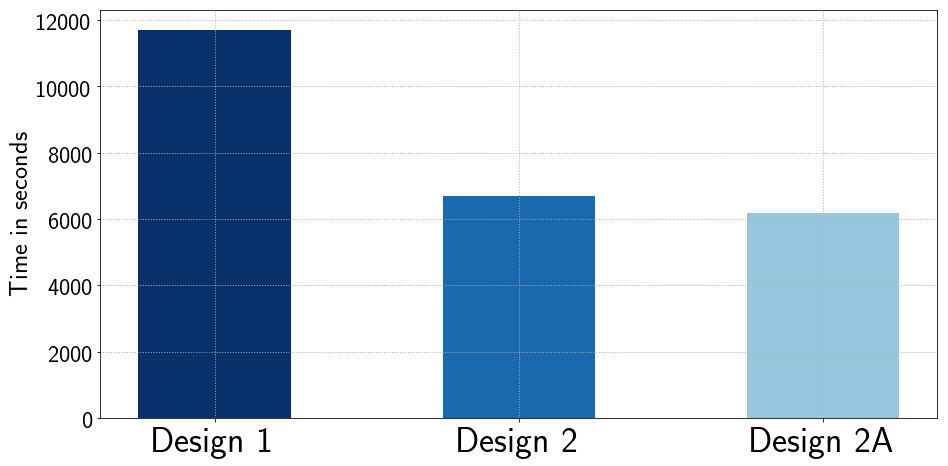

In [14]:
fig, axis = plt.subplots(nrows=1,ncols=1, figsize=(15,7.5))
x1 = np.arange(3)
_ = axis.bar(x1[0], des1DF['TTX'].mean(), width=0.5, color=blues(300), label='Design 1 TTX')
_ = axis.bar(x1[1], des2DF['TTX'].mean(), width=0.5, color=blues(200), label='Design 2 TTX')
_ = axis.bar(x1[2], des2ADF['TTX'].mean(), width=0.5, color=blues(100), label='Design 2A TTX')
_ = axis.set_xticks([0,1,2])
_ = axis.grid(which='both', linestyle=':', linewidth=1)
_ = axis.set_xticklabels(['Design 1', 'Design 2','Design 2A'], fontsize=36)
_ = axis.set_ylabel('Time in seconds', fontsize=26)
_ = axis.set_yticklabels(axis.get_yticks().astype('int').tolist(),fontsize=24)
#fig.savefig('geo_ttx.pdf',dpi=800,bbox='tight')

In [15]:
dist_overhead = np.load('../Data/dist_dataset.npy')

In [16]:
DiscDurations = [1861.404363739,
1872.631383787,
1870.355146581,
1852.347904858,
1857.771844937,
1868.644424397,
1873.176510421,
1851.527881958,
1870.128898667,
1856.676059379]

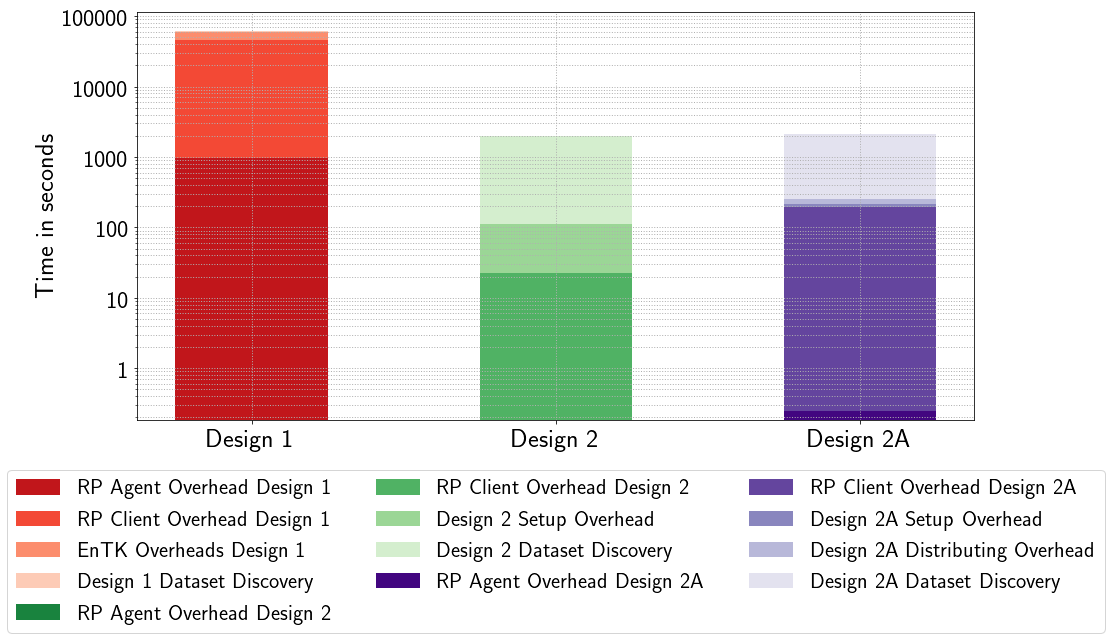

In [17]:
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15,7.5))
x1 = np.arange(3)

_ = axis.bar(x1[0], des1DF['AgentOverhead'].mean(),width=0.5, color=reds(200),label='RP Agent Overhead Design 1')
_ = axis.bar(x1[0], des1DF['ClientOverhead'].mean(), bottom=des1DF['AgentOverhead'].mean(),width=0.5, color=reds(150),label='RP Client Overhead Design 1')
_ = axis.bar(x1[0], des1DF['EnTKOverhead'].mean(),bottom=des1DF['ClientOverhead'].mean()+des1DF['AgentOverhead'].mean(),width=0.5, color=reds(100),label='EnTK Overheads Design 1')
_ = axis.bar(x1[0], np.mean(DiscDurations), yerr=np.std(DiscDurations), bottom=des1DF['ClientOverhead'].mean()+des1DF['AgentOverhead'].mean() + des1DF['EnTKOverhead'].mean(), 
                width=0.5, color=reds(50),label='Design 1 Dataset Discovery')

_ = axis.bar(x1[1],des2DF['AgentOverhead'].mean(),width=0.5, color=greens(200),label='RP Agent Overhead Design 2')
_ = axis.bar(x1[1],des2DF['ClientOverhead'].mean(),bottom=des2DF['AgentOverhead'].mean(),width=0.5, color=greens(150),label='RP Client Overhead Design 2')
_ = axis.bar(x1[1],(des2DF['SetupOverhead'] + des2DF['SetupOverhead2']).mean(),bottom=des2DF['ClientOverhead'].mean()+des2DF['AgentOverhead'].mean(),width=0.5, color=greens(100),label='Design 2 Setup Overhead')
_ = axis.bar(x1[1],np.mean(DiscDurations), yerr=np.std(DiscDurations), bottom=des2DF['ClientOverhead'].mean()+des2DF['AgentOverhead'].mean() + (des2DF['SetupOverhead']+des2DF['SetupOverhead2']).mean(),
                width=0.5, color=greens(50),label='Design 2 Dataset Discovery')


_ = axis.bar(x1[2],des2ADF['AgentOverhead'].mean(),#yerr=des2ADF['AgentOverhead'].std(),
                width=0.5, color=purples(250),label='RP Agent Overhead Design 2A',log=1)
_ = axis.bar(x1[2],des2ADF['ClientOverhead'].mean(),#yerr=des2ADF['ClientOverhead'].std(),
                bottom=des2ADF['AgentOverhead'].mean(),width=0.5, color=purples(200),label='RP Client Overhead Design 2A')
_ = axis.bar(x1[2],des2ADF['SetupOverhead'].mean(),#yerr=des2ADF['SetupOverhead'].std(),
                bottom=des2ADF['ClientOverhead'].mean()+des2ADF['AgentOverhead'].mean(),width=0.5, color=purples(150),label='Design 2A Setup Overhead')
_ = axis.bar(x1[2],dist_overhead.mean(),yerr=dist_overhead.std(),
                bottom=des2ADF['ClientOverhead'].mean()+des2ADF['AgentOverhead'].mean()+des2ADF['SetupOverhead'].mean(),width=0.5, color=purples(100),label='Design 2A Distributing Overhead')
_ = axis.bar(x1[2],np.mean(DiscDurations), yerr=np.std(DiscDurations),
                bottom=des2ADF['ClientOverhead'].mean()+des2ADF['AgentOverhead'].mean()+des2ADF['SetupOverhead'].mean() + dist_overhead.mean(),
                width=0.5, color=purples(50),label='Design 2A Dataset Discovery')


_ = axis.set_xticks([0,1,2])
_ = axis.grid(which='both', linestyle=':', linewidth=1)
_ = axis.set_ylabel('Time in seconds', fontsize=26)
_ = axis.set_xticklabels(['Design 1', 'Design 2','Design 2A'], fontsize=26)
_ = axis.set_yticks([1,10,100,1000,10000,100000])
_ = axis.set_yticklabels(axis.get_yticks().astype('int').tolist(),fontsize=24)
_ = axis.legend(fontsize=22,loc = 'lower center', bbox_to_anchor = (0,-.55,1,1), ncol=3)
#_ = fig.subplots_adjust(bottom=.405)
#fig.savefig('geo_overheads.pdf',dpi=800,bbox='tight',pad_inches=0)